In [21]:
import urllib.request
import anndata
import scanpy as sc
import muon as mu
import pandas as pd
from pathlib import Path
import os
import upsetplot
from ikarus import gene_list, classifier, utils, data

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

# Asha Tumor Classification

- Tumor Dataset:
    - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7447441/
    - GEO: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE123366
    
- Normal Dataset:
    - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5723634/
    - GEO: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE106273

## Load Datasets

### Asha - Dataset for Tumor Classification

In [22]:
asha_original = mu.read(Path("data/asha-integrated-rna-prot-gzip.h5mu")).mod["rna"]
asha_original.var['gene_symbol'] = asha_original.var.index

# Use raw counts for preprocessing
asha_original.X = asha_original.raw.X
asha_original = data.preprocess_adata(asha_original)

In [24]:
# Make a copy for the nonimmune only cells for analysis
asha = asha_original.copy()

# Filter out the immune cells in the asha dataset
asha_nonimmune = ['Brush cell (Tuft cell)|Mast cell', 
                  'Ciliated cell|Epithelial cell',
                  'Dendritic cell|Brush cell (Tuft cell)',
                  'Endothelial cell',
                  'Epithelial cell|Ciliated cell', 
                  'Epithelial cell|Stem cell',
                  'Fibroblast|Endothelial cell']

asha = asha[asha.obs['cell type'].isin(asha_nonimmune), :]

In [25]:
asha

View of AnnData object with n_obs × n_vars = 4181 × 21050
    obs: 'Sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cell type', 'condition'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'gene_symbol'
    uns: 'cell type_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

### Tumor

In [26]:
tumor = sc.read_10x_mtx("tumor/", prefix="GSE123366_Combined_")

# Sample type is to represent the tumor status of the dataset
tumor.obs['sample_type'] = 'Tumor'
tumor.var['gene_symbol'] = tumor.var.index

tumor = data.preprocess_adata(tumor)

In [27]:
tumor

AnnData object with n_obs × n_vars = 13745 × 31053
    obs: 'sample_type'
    var: 'gene_ids', 'feature_types', 'gene_symbol'
    uns: 'log1p'

### Normal

In [28]:
normal1 = sc.read_10x_mtx("normal/", prefix="GSM2834498_NP_1_")
normal2 = sc.read_10x_mtx("normal/", prefix="GSM2834499_NP_2_")

normal3 = sc.read_10x_mtx("normal/", prefix="GSM2834500_G_1_")
normal4 = sc.read_10x_mtx("normal/", prefix="GSM2834501_G_2_")

normal5 = sc.read_10x_mtx("normal/", prefix="GSM2834502_L_1_")
normal6 = sc.read_10x_mtx("normal/", prefix="GSM2834503_L_2_")

normal7 = sc.read_10x_mtx("normal/", prefix="GSM2834504_PI_1_")
normal8 = sc.read_10x_mtx("normal/", prefix="GSM2834505_PI_2_")

In [29]:
normal = sc.concat([normal1, normal2, normal3, normal4, normal5, normal6, normal7, normal8], axis=0)
normal.obs['sample_type'] = 'Normal'
normal.var['gene_symbol'] = normal.var.index

# Sample the same number of cells as the tumor cells
sc.pp.subsample(normal, n_obs=tumor.shape[0], random_state=0)

normal = data.preprocess_adata(normal)

/Users/wesleykwong/virtualenvs/scellai2/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/wesleykwong/virtualenvs/scellai2/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [30]:
normal

AnnData object with n_obs × n_vars = 13745 × 27998
    obs: 'sample_type'
    var: 'gene_symbol'
    uns: 'log1p'

In [31]:
# Code to load the Tabula muris dataset
#normal = sc.read_h5ad("normal/droplet_Mammary_Gland_seurat_tiss.h5ad")
#normal.obs['sample_type'] = 'Normal'
#normal.var['gene_symbol'] = normal.var.index

# Use raw counts for preprocessing
#normal.X = normal.layers['counts']
#normal = data.preprocess_adata(normal)

### Filter for only overlapping genes

In [32]:
tumor_and_normal = sc.concat([tumor, normal], keys=['Tumor', 'Normal'], axis=0)
tumor_and_normal.var['gene_symbol'] = tumor_and_normal.var.index

# Keep only the genes that overlap between Asha and the training data for gene model selection
common_genes = list(set(tumor_and_normal.var['gene_symbol']).intersection(set(asha.var['gene_symbol'])))

tumor_and_normal_percentage = len(common_genes)/len(tumor_and_normal)*100
asha_percentage = len(common_genes)/len(asha.var['gene_symbol'])*100

print("Overlapping genes in tumor/normal dataset: "+str(np.round(tumor_and_normal_percentage, 2))+"%")
print("Overlapping genes in Asha dataset: "+str(np.round(asha_percentage, 2))+"%")

tumor_and_normal = tumor_and_normal[:, common_genes]
asha = asha[:, common_genes]

/Users/wesleykwong/virtualenvs/scellai2/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Overlapping genes in tumor/normal dataset: 65.66%
Overlapping genes in Asha dataset: 85.74%


### Generate Train Test Split

In [33]:
test_size = 0.2

# Subsample from tumor_and_normal without affecting the original dataset
adata_test = sc.pp.subsample(tumor_and_normal, fraction=test_size, copy=True, random_state=0)

# Select the other nonsampled cells as the train set
adata_train = tumor_and_normal[~tumor_and_normal.obs.index.isin(adata_test.obs.index), :]

/Users/wesleykwong/virtualenvs/scellai2/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [34]:
adata_train

View of AnnData object with n_obs × n_vars = 21956 × 18049
    obs: 'sample_type'
    var: 'gene_symbol'

In [35]:
adata_train.obs.reset_index().groupby('sample_type').count()

,index
sample_type,
Normal,10928
Tumor,11028


In [36]:
adata_test.obs.reset_index().groupby('sample_type').count()

,index
sample_type,
Normal,2781
Tumor,2717


## Create Gene List

Identify genes upregulated in the tumor samples

In [37]:
adatas = {}
adatas["training_set"] = adata_train
adatas["validation_set"] = adata_test

In [38]:
names = [
    "training_set"
]
obs_names = [
    'sample_type'
]
label_upregs = [
    "Tumor"
]
label_downregs = [
    "Normal"
]

In [39]:
tumor_genes = gene_list.create_all(
    label_upregs_list=label_upregs,
    label_downregs_list=label_downregs,
    adatas_dict=adatas,
    names_list=names,
    obs_names_list=obs_names,
    integration_fun=utils.intersection_fun,
    top_x=300
)

/Users/wesleykwong/virtualenvs/scellai2/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [40]:
tumor_genes = list(tumor_genes.values())[0]
tumor_genes

['mt-Nd4l',
 'Srp54a',
 'Csprs',
 'A2m',
 'Olfr482',
 'Schip1',
 'AC125149.3',
 'Tmem254a',
 'Gm26619',
 'Olfr889',
 'Wnt7a',
 'A530040E14Rik',
 'Syt6',
 'Olfr1369-ps1',
 'Hist1h2br',
 'Ibsp',
 'Gbp6',
 'Gm38246',
 'Efcab6',
 'Olfr279',
 'Vmn2r96',
 'Ahsg',
 'Cyp2c55',
 '2310039L15Rik',
 'Gm4631',
 'Olfr552',
 'Mef2b',
 'Klhl33',
 'Gm28321',
 'Dmrta2os',
 'Gm12606',
 'Vmn1r43',
 'Hist1h2ao',
 'Gabrr1',
 'Fndc3c1',
 'Gm20443',
 'BC039966',
 'Cd200r3',
 'Hapln1',
 'Bfsp2',
 'Gm17655',
 'Gm29865',
 'Prmt8',
 'Zfp345',
 'Fkbp6',
 'Rlbp1',
 'Gm10701',
 'Gm43409',
 'C330002G04Rik',
 'Cadps',
 'Gata4',
 'Pzp',
 'Plac9b',
 'Apol7c',
 'Prm1',
 'Chil3',
 'Zfp781',
 'Krtap1-5',
 'Lingo3',
 'Trim34b',
 'Gm8013',
 'Klk1b9',
 'Kcnq3',
 'Gm10639',
 'Dcdc2c',
 'Gm14827',
 '2810049E08Rik',
 'Gm14002',
 'Fgf22',
 'Olfr1124',
 'Olfr57',
 'Dmrta1',
 'Spink6',
 'Gm15389',
 'Ttll2',
 'Olfr46',
 'Dppa2',
 'Nphs1',
 'Gm16028',
 'Runx2os2',
 'Gm43056',
 'Gm12022',
 'Iqcf1',
 'Prl6a1',
 'Gm20406',
 'Gm5431',
 '

Identify genes upregulated in the normal sample

In [41]:
names = [
    "training_set"
]
obs_names = [
    'sample_type'
]
label_upregs = [
    "Normal"
]
label_downregs = [
    "Tumor"
]

In [42]:
normal_genes = gene_list.create_all(
    label_upregs_list=label_upregs,
    label_downregs_list=label_downregs,
    adatas_dict=adatas,
    names_list=names,
    obs_names_list=obs_names,
    integration_fun=utils.intersection_fun,
    top_x=300
)

/Users/wesleykwong/virtualenvs/scellai2/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [43]:
normal_genes = list(normal_genes.values())[0]
normal_genes

['Atp5o',
 '4930481A15Rik',
 'Trim12a',
 'Gm30613',
 'Xkr4',
 'Gm15821',
 'Gm3468',
 'Clec1a',
 'Fcrl1',
 'Gm3248',
 'Gm10406',
 'Asic4',
 'Zfp804b',
 'Spaca1',
 'Cd207',
 'Siglech',
 'Frmpd4',
 'Gzmb',
 'Gm29200',
 'Mybpc1',
 'Aqp7',
 'Mill1',
 'Pln',
 'Ppp1r3d',
 'Ccr2',
 'Card11',
 'Lpar5',
 'Scn3a',
 'Trim5',
 'Gm8281',
 'Cd209a',
 'Gm525',
 'Mcemp1',
 'Gm21847',
 'Rtp3',
 'Hoxd4',
 'Gm28077',
 'Klrb1c',
 'Gm9922',
 'Gm16033',
 '1600010M07Rik',
 'Gm15510',
 'Gpr1',
 'Dok6',
 '4933424M12Rik',
 'Gm16208',
 'Tas2r143',
 'Gm26586',
 'Fcnaos',
 'Elmod1',
 'Alk',
 'Ms4a4a',
 'Pnldc1',
 'Myl10',
 'Klra1',
 'Gm33280',
 'Tmem150b',
 'Gm26679',
 'Gm14377',
 'Gm13012',
 'Gpr55',
 'Cd226',
 'P2ry13',
 'Gm31363',
 'Unc5d',
 'Dmrt2',
 'Mmrn1',
 'Slc28a2',
 'Gm10369',
 'Tssk3',
 'Ms4a14',
 'Xcr1',
 'Gm16144',
 'Klrc2',
 'Mccc1os',
 'Gm11707',
 'Nlrp1b',
 'Htr7',
 'Gm15478',
 'Asb14',
 'Dpep3',
 'Pnpla3',
 'Fam217a',
 'Gm19585',
 'BC049352',
 'Khdc3',
 'Hnf4aos',
 'Prap1',
 'Slc2a2',
 'Gm33051',
 

Remove genes which are overlapping with the union of tumor genes from all pair-wise comparisons with Tumor being the upregulated class (see above).

In [44]:
overlap = list(set(tumor_genes) & set(normal_genes))
normal_genes = list(set(normal_genes) - set(overlap))

In [45]:
# Export as .gmt file
gene_list.save_gmt([normal_genes, tumor_genes], ["Normal", "Tumor"], out_dir="out")

# Train Model from Signatures

In [46]:
signatures_path = Path("out/signatures.gmt")

In [47]:
pd.read_csv(signatures_path, sep="\t", header=None)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,300,301
0,Normal,ikarus,Asb14,Heatr4,Ldhc,1600010M07Rik,Casq2,Gm20652,D630008O14Rik,Lmx1a,...,Gm3248,Pnp2,Disp2,Ccr2,Unc5d,Gm28077,Mybpc3,Gm12866,Kmo,Myh11
1,Tumor,ikarus,mt-Nd4l,Srp54a,Csprs,A2m,Olfr482,Schip1,AC125149.3,Tmem254a,...,Tmprss11e,Spp1,Npnt,A730032A03Rik,Fzd9,Ccnb1ip1,Wnt10b,Gm15987,Hhatl,Cracr2a


In [48]:
# Cell to train classifier
# Set adapt_signatures either there is >80% gene overlap between tumor and normal adata
# or if filtered out the uncommon genes between the datasets
model = classifier.Ikarus(signatures_gmt=signatures_path, out_dir="out", adapt_signatures=False)

train_adata_list = [adatas['training_set']] 
train_names_list = ['training_set'] 
obs_columns_list = ['sample_type'] 

model.fit(train_adata_list, train_names_list, obs_columns_list, save=True)

In [49]:
# Cell to load trained classifier
model_path = Path("out/core_model.joblib")
model = classifier.Ikarus(signatures_gmt=signatures_path, out_dir="out")
model.load_core_model(model_path)

In [50]:
def plot_confusion_matrix(
    y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues, ax=None
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.rcParams["figure.figsize"] = [6, 4]
    # print(classes)
    if not title:
        if normalize:
            title = "Normalized confusion matrix"
        else:
            title = "Confusion matrix, without normalization"

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred, labels=classes)
    # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    if ax is None:
        (fig, ax) = plt.subplots()

    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel="True Label",
        xlabel="Predicted Label",
    )
    for item in (
        [ax.title, ax.xaxis.label, ax.yaxis.label]
        + ax.get_xticklabels()
        + ax.get_yticklabels()
    ):
        item.set_fontsize(12)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                format(cm[i, j], fmt),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    return fig, ax

# Apply Model on Training Data

In [51]:
_ = model.predict(adatas['training_set'], 'training_set', save=True)

/Users/wesleykwong/virtualenvs/scellai2/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:540: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['hvg'] = {'flavor': flavor}
/Users/wesleykwong/virtualenvs/scellai2/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


converged at iteration step: 12 with 0.0008 < 0.001


In [52]:
# Compute the UMAP
_ = model.get_umap(adatas['training_set'], 'training_set', save=True)

/Users/wesleykwong/virtualenvs/scellai2/lib/python3.9/site-packages/ikarus/classifier.py:461: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["core_pred"] = self.results["core_pred"].values
/Users/wesleykwong/virtualenvs/scellai2/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/wesleykwong/virtualenvs/scellai2/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [53]:
# Load prediction results and the AnnData object including the just computed UMAP coordinates
path = Path("out/training_set")
adata_train_results = pd.read_csv(path / "prediction.csv", index_col=0)
adata_train = anndata.read_h5ad(path / "adata_umap.h5ad")

/Users/wesleykwong/virtualenvs/scellai2/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


              precision    recall  f1-score   support

      Normal       1.00      0.88      0.94     10928
       Tumor       0.89      1.00      0.94     11028

    accuracy                           0.94     21956
   macro avg       0.95      0.94      0.94     21956
weighted avg       0.95      0.94      0.94     21956



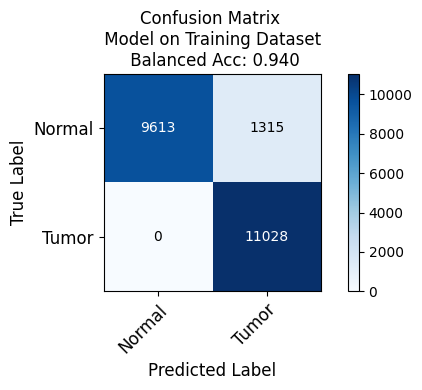

In [54]:
y = adata_train.obs["sample_type"]
y_pred_lr = adata_train.obs["final_pred"]
acc = metrics.balanced_accuracy_score(y, y_pred_lr)
print(metrics.classification_report(y, y_pred_lr, labels=["Normal", "Tumor"]))
fig, ax = plot_confusion_matrix(
    y,
    y_pred_lr,
    classes=["Normal", "Tumor"],
    title=f"Confusion Matrix \n Model on Training Dataset \n Balanced Acc: {acc:.3f}",
)
fig.tight_layout()

/Users/wesleykwong/virtualenvs/scellai2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


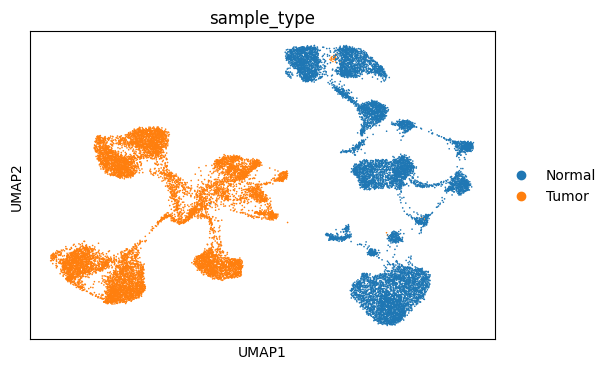

In [55]:
sc.pl.umap(adata_train, color='sample_type')

/Users/wesleykwong/virtualenvs/scellai2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


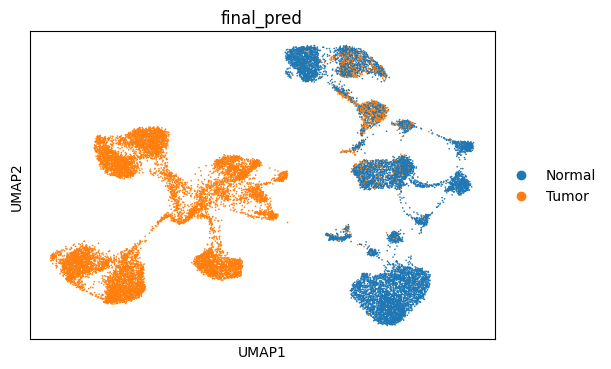

In [56]:
sc.pl.umap(adata_train, color='final_pred')

# Apply Model on Validation Data

In [57]:
_ = model.predict(adatas["validation_set"], "validation_set", save=True)

/Users/wesleykwong/virtualenvs/scellai2/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:540: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['hvg'] = {'flavor': flavor}
/Users/wesleykwong/virtualenvs/scellai2/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


converged at iteration step: 4 with 0.0005 < 0.001


In [58]:
# Compute the UMAP
_ = model.get_umap(adatas["validation_set"], "validation_set", save=True)

In [71]:
# Load prediction results and the AnnData object including the just computed UMAP coordinates
path = Path("out/validation_set")
adata_test_results = pd.read_csv(path / "prediction.csv", index_col=0)
adata_test = anndata.read_h5ad(path / "adata_umap.h5ad")

/Users/wesleykwong/virtualenvs/scellai2/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


              precision    recall  f1-score   support

      Normal       0.99      1.00      1.00      2781
       Tumor       1.00      0.99      1.00      2717

    accuracy                           1.00      5498
   macro avg       1.00      1.00      1.00      5498
weighted avg       1.00      1.00      1.00      5498



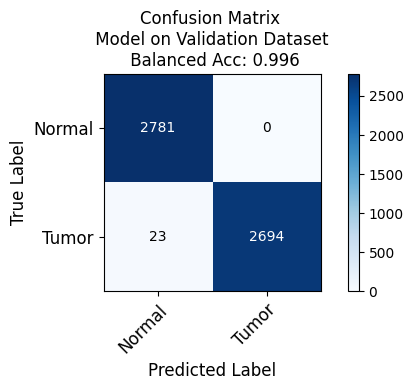

In [72]:
y = adata_test.obs["sample_type"]
y_pred_lr = adata_test.obs["final_pred"]
acc = metrics.balanced_accuracy_score(y, y_pred_lr)
print(metrics.classification_report(y, y_pred_lr, labels=["Normal", "Tumor"]))
fig, ax = plot_confusion_matrix(
    y,
    y_pred_lr,
    classes=["Normal", "Tumor"],
    title=f"Confusion Matrix \n Model on Validation Dataset \n Balanced Acc: {acc:.3f}",
)
fig.tight_layout()

# Apply Model on Asha Testing Data

## Asha Nonimmune Cell Prediction

In [61]:
_ = model.predict(asha, 'asha_tumor_prediction', save=True)

/Users/wesleykwong/virtualenvs/scellai2/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:540: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['hvg'] = {'flavor': flavor}


converged at iteration step: 7 with 0.0007 < 0.001


In [62]:
# Load prediction results and the AnnData object including the just computed UMAP coordinates
asha_path = Path("out/asha_tumor_prediction")
results = pd.read_csv(asha_path / "prediction.csv", index_col=0)

results.index = asha.obs.index
asha.obs['final_pred'] = results[['final_pred']].astype('category')

/var/folders/zl/pp469c5x4fl1hf56vdmclq6r0000gn/T/ipykernel_50789/124988352.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  asha.obs['final_pred'] = results[['final_pred']].astype('category')


/Users/wesleykwong/virtualenvs/scellai2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


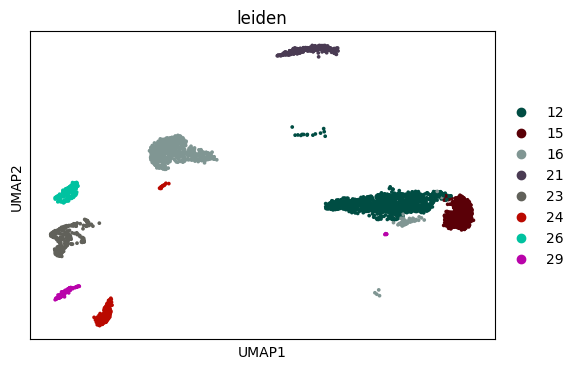

In [63]:
sc.pl.umap(asha, color='leiden')

/Users/wesleykwong/virtualenvs/scellai2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


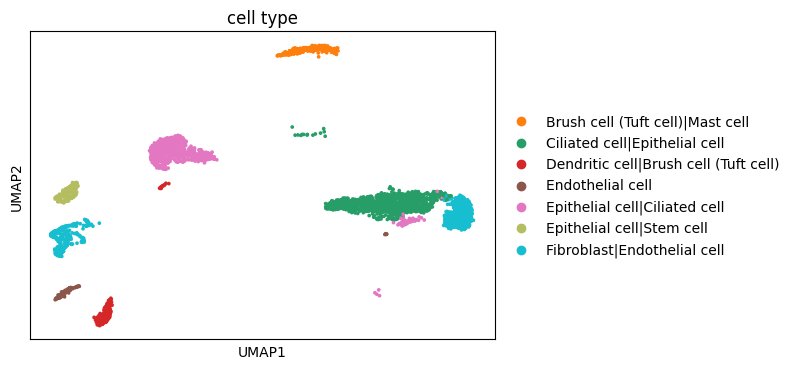

In [64]:
sc.pl.umap(asha, color='cell type')

/Users/wesleykwong/virtualenvs/scellai2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


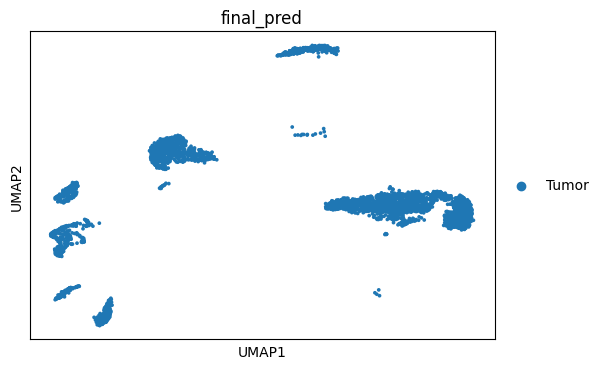

In [65]:
sc.pl.umap(asha, color='final_pred')

## Asha Cell Prediction -- All

In [66]:
_ = model.predict(asha_original, 'asha_all_tumor_prediction', save=True)

/Users/wesleykwong/virtualenvs/scellai2/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:540: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['hvg'] = {'flavor': flavor}


converged at iteration step: 7 with 0.0002 < 0.001


In [67]:
# Load prediction results and the AnnData object including the just computed UMAP coordinates
asha_original_path = Path("out/asha_all_tumor_prediction")
asha_original_results = pd.read_csv(asha_original_path / "prediction.csv", index_col=0)

asha_original_results.index = asha_original.obs.index
asha_original.obs['final_pred'] = asha_original_results[['final_pred']].astype('category')

/Users/wesleykwong/virtualenvs/scellai2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


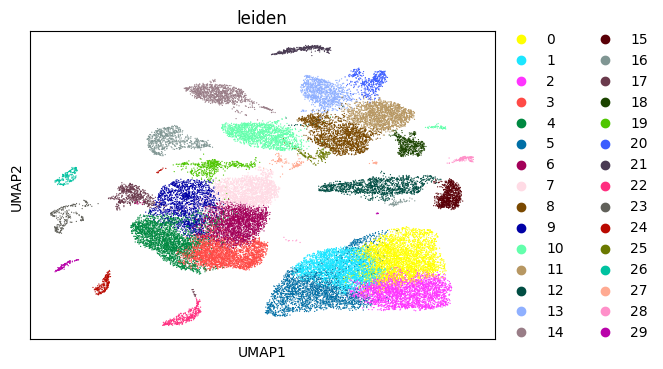

In [68]:
sc.pl.umap(asha_original, color='leiden')

/Users/wesleykwong/virtualenvs/scellai2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


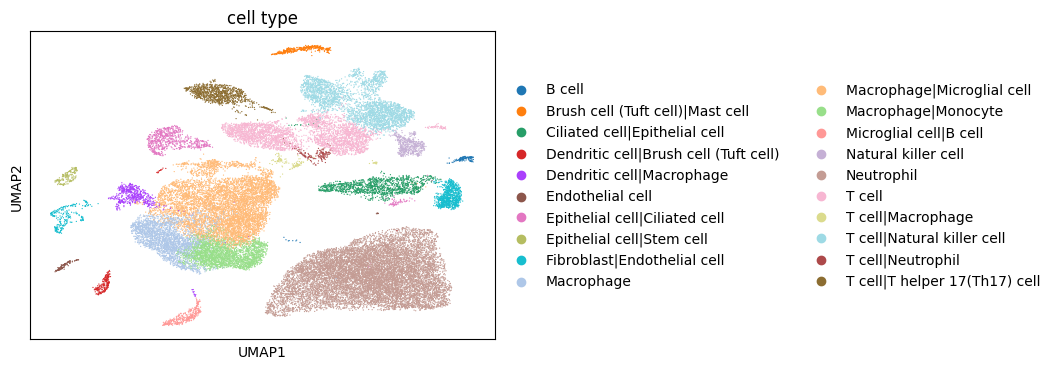

In [69]:
sc.pl.umap(asha_original, color='cell type')

/Users/wesleykwong/virtualenvs/scellai2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


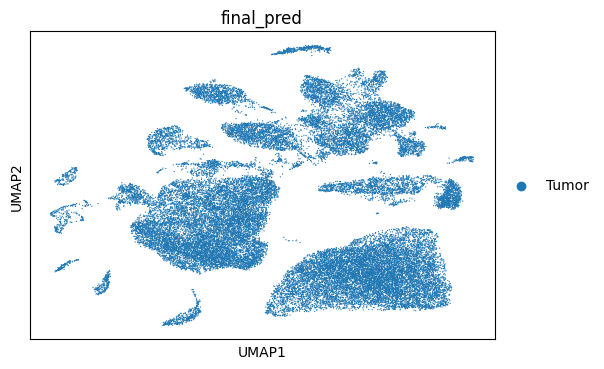

In [70]:
sc.pl.umap(asha_original, color='final_pred')